<a href="https://colab.research.google.com/github/Mincheol2/VAAE/blob/main/Vanila_VAE/VAE_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/gammaAE

/content/drive/MyDrive/gammaAE


In [3]:
import torch

def sampling(N, mu, cov, nu, device):
    '''
    N      : sample size
    D      : dimension
    mu     : torch tensor [D, ]
    cov    : torch tensor [D x D] (positive definite matrix)
    nu     : degree of freedom 
    device : 'cuda:0' or 'cpu'
    '''

    MVN_dist = torch.distributions.MultivariateNormal(torch.zeros_like(mu), cov)
    eps = MVN_dist.sample(sample_shape=torch.tensor([N])).to(device)
    
    if nu != 0 : 
        chi_dist = torch.distributions.chi2.Chi2(torch.tensor([nu]))
        v = chi_dist.sample().to(device)
        eps /= v

    return mu.to(device) + eps

In [4]:
# from util import make_reproducibility
import random
import numpy as np

def make_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device(f'cuda:0' if USE_CUDA else "cpu")

make_reproducibility(1000)

input_dim = 10
z_dim = 3

N_1 = 1800
mu_1 = torch.randn(input_dim)
X_1 = torch.randn(input_dim * 2, input_dim)
cov_1 = X_1.T @ X_1
nu_1 = 5

sample_1 = sampling(N_1, mu_1, 4 * cov_1, nu_1, DEVICE)

N_2 = 200
mu_2 = torch.randn(input_dim)
X_2 = torch.randn(input_dim * 2, input_dim)
cov_2 = X_2.T @ X_2
nu_2 = 8

sample_2 = sampling(N_2, mu_2 + 5,  cov_2, nu_2, DEVICE)

t_sample = torch.cat([sample_1, sample_2])
# t_sample = sample_1

In [5]:
from torch.utils.data import DataLoader

class MYTensorDataset(torch.utils.data.Dataset) :
    def __init__(self, *tensors) -> None:
        self.tensors = tensors

    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

simulation_trainset = MYTensorDataset(t_sample)

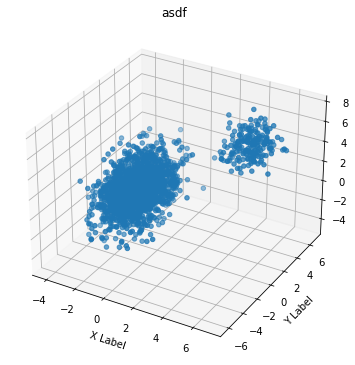

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(projection='3d')


ax.scatter(t_sample.cpu().numpy()[:,0], 
           t_sample.cpu().numpy()[:,1], 
           t_sample.cpu().numpy()[:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('asdf')

plt.show()

In [7]:
import torch.nn as nn
from torch.nn import functional as F

'''
    log version of normalizing constant for t-distribution
'''
def log_t_normalizing_const(nu, d):
    nom = torch.lgamma(torch.tensor((nu+d)/2))
    denom = torch.lgamma(torch.tensor(nu/2)) + d/2 * (np.log(nu) + np.log(np.pi))
    return nom - denom


def gamma_regularizer(mu, logvar, p_dim, const_2bar1, gamma, tau, nu):
    '''
        p_dim : data dim
        q_dim : latent dim

        output : 1/N sum_{i=1}^{N} ||mu(X_i)||^2 + Sigma(X_i)|^{-gamma /2}
    '''
    mu_norm_sq = torch.linalg.norm(mu, ord=2, dim=1).pow(2)
    trace_var = nu / (nu + p_dim - 2) * torch.sum(logvar.exp(),dim=1)
    log_det_var = -gamma / (2+2*gamma) * torch.sum(logvar,dim=1)

    return torch.sum(mu_norm_sq + trace_var - nu * const_2bar1 * log_det_var.exp() + nu * tau)



In [8]:
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from loss import log_t_normalizing_const, gamma_regularizer, Gamma_Family
# from loss import *


class Encoder(nn.Module):
    def __init__(self, input_dim, zdim, nu, DEVICE, recon_sigma = 0.5, reg_weight = 1.0):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.zdim = zdim
        self.nu = nu
        self.device = DEVICE
        self.recon_sigma = recon_sigma
        self.reg_weight = reg_weight

        self.fc1 = nn.Linear(self.input_dim, self.input_dim * 2)
        self.fc2 = nn.Linear(self.input_dim * 2, self.input_dim * 2)
        self.latent_mu = nn.Linear(self.input_dim * 2, self.zdim)
        self.latent_var = nn.Linear(self.input_dim * 2, self.zdim)
        
            
        #precomputing constants
        if self.nu != 0:
            self.pdim = input_dim
            self.qdim = self.zdim
            
            self.gamma = -2 / (self.nu + self.pdim + self.qdim)
            
            log_tau_base = -self.pdim * np.log(self.recon_sigma) + log_t_normalizing_const(self.nu, self.pdim) - np.log(self.nu + self.pdim - 2) + np.log(self.nu-2)
            
            const_2bar1_term_1 = (1 + self.qdim / (self.nu + self.pdim -2))
            const_2bar1_term_2_log = -self.gamma / (1+self.gamma) * log_tau_base
            self.const_2bar1 = const_2bar1_term_1 * const_2bar1_term_2_log.exp()
            
            
            ## 230308 : add new constant nu*tau
            log_tau = 1 / (self.nu + self.pdim - 2 ) * log_tau_base
            self.tau = log_tau.exp()
    
    def reparameterize(self, mu, logvar):
        if self.nu == 0:
            std = torch.exp(0.5 * logvar) # diagonal mat
            eps = torch.randn_like(std) # Normal dist : eps ~ N(0, I)
            return mu + std * eps
        else:
            '''
                Sampling algorithm
                Let nu_prime = nu + p_dim
                1. Generate v ~ chiq(nu_prime) and eps ~ N(0, I), independently.
                2. Caculate x = mu + std * eps / (sqrt(v/nu_prime)), where std = sqrt(nu/(nu_prime) * var)
            '''
            nu_prime = self.nu + self.zdim
            MVN_dist = torch.distributions.MultivariateNormal(torch.zeros(self.zdim), torch.eye(self.zdim))
            chi_dist = torch.distributions.chi2.Chi2(torch.tensor([nu_prime]))
            
            # Student T dist : [B, z_dim]
            eps = MVN_dist.sample(sample_shape=torch.tensor([mu.shape[0]])).to(self.device)
            
            std = torch.sqrt((self.nu / nu_prime) * torch.exp(0.5 * logvar))
            v = chi_dist.sample().to(self.device)
            return mu + std * eps * torch.sqrt(nu_prime / v)

    def forward(self, x):
        x = x.view(-1,self.input_dim)
        x = F.leaky_relu(self.fc1(x))
        # x = F.leaky_relu(self.fc2(x))
        mu = self.latent_mu(x)
        logvar = self.latent_var(x)
        z = self.reparameterize(mu, logvar)

        return z, mu, logvar

    def loss(self, mu, logvar):
        if self.nu == 0:
            # KL divergence
            reg_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        else:
            # gammaAE regularizer
            reg_loss = gamma_regularizer(mu, logvar, self.pdim, self.const_2bar1, self.gamma, self.tau, self.nu)
        
        return reg_loss * self.reg_weight

class Decoder(nn.Module):
    def __init__(self, output_dim, zdim, recon_sigma = 0.5):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.zdim = zdim
        self.recon_sigma = 0.5
        self.fc3 = nn.Linear(self.zdim, self.zdim * 2)
        # self.fc4 = nn.Linear(self.zdim * 2, self.zdim * 2)
        self.fc5 = nn.Linear(self.zdim * 2, self.output_dim)

    def forward(self, enc_z):
        z = F.leaky_relu(self.fc3(enc_z))
        # z = F.leaky_relu(self.fc4(z))
        prediction = self.fc5(z)
        return prediction

    def loss(self, recon_x, x):
        recon_loss = F.mse_loss(recon_x, x, reduction = 'sum') / self.recon_sigma**2
        
        return recon_loss


In [9]:
class gammaAE():
    def __init__(self, dataset, input_dim, zdim, nu, DEVICE, 
                 recon_sigma = 0.5, reg_weight = 1.0, lr = 1e-4, batch_size = 64):
        self.dataset = dataset
        self.input_dim = input_dim
        self.zdim = zdim
        self.nu = nu
        self.DEVICE = DEVICE
        self.recon_sigma = recon_sigma
        self.reg_weight = reg_weight
        self.lr = lr
        self.batch_size = batch_size

        self.encoder = Encoder(self.input_dim, self.zdim, self.nu, 
                               self.DEVICE, self.recon_sigma, self.reg_weight).to(self.DEVICE)
        self.decoder = Decoder(self.input_dim, self.zdim, self.recon_sigma).to(self.DEVICE)
        self.opt = optim.Adam(list(self.encoder.parameters()) +
                 list(self.decoder.parameters()), lr=self.lr, eps=1e-6, weight_decay=1e-5)


        self.trainloader = torch.utils.data.DataLoader(self.dataset, batch_size = self.batch_size, shuffle = True)

    def train(self, epoch):
        self.encoder.train()
        self.decoder.train()
        total_loss = []
        for batch_idx, data in enumerate(self.trainloader):
            data = data[0].to(self.DEVICE)
            self.opt.zero_grad()
            z, mu, logvar = self.encoder(data)
            reg_loss = self.encoder.loss(mu, logvar)
            recon_data = self.decoder(z)
            recon_loss = self.decoder.loss(recon_data, data.view(-1,self.input_dim))
            current_loss = reg_loss + recon_loss
            current_loss.backward()

            total_loss.append(current_loss.item())
            
            self.opt.step()

        #     if batch_idx % 200 == 0:
        #         N = data.shape[0]
        #         denom = len(self.trainloader.dataset)/args.batch_size
        #         writer.add_scalar("Train/Reconstruction Error", recon_loss.item() / N, batch_idx + epoch * denom )
        #         writer.add_scalar("Train/Regularizer", reg_loss.item() / N, batch_idx + epoch * denom )
        #         writer.add_scalar("Train/Total Loss" , current_loss.item() / N, batch_idx + epoch * denom )
        # return reg_loss.item() / N, recon_loss.item() / N, current_loss.item() / N

    # def test(self,epoch,writer):
    # def test(self, epoch) :
    #     self.encoder.eval()
    #     self.decoder.eval()
    #     with torch.no_grad():
    #         for batch_idx, (data, labels) in enumerate(self.testloader):
    #             data = data.to(self.DEVICE)
    #             z, mu, logvar = self.encoder(data)
                            
    #             reg_loss = self.encoder.loss(mu, logvar)
    #             recon_img = self.decoder(z)
    #             data = data.view(-1,784)
    #             recon_loss = self.decoder.loss(recon_img,data)
    #             current_loss = reg_loss + recon_loss

    #             ## Caculate SSIM, PSNR, RMSE ##
    #             img1 = data.cpu().squeeze(dim=1).numpy()
    #             img2 = recon_img.cpu().view_as(data).squeeze(dim=1).numpy()
    #             ssim_test = 0
    #             psnr_test = 0
    #             rmse_test = 0
    #             N = img1.shape[0]
    #             for i in range(N):
    #                 ssim_test += ssim(img1[i], img2[i])
    #                 psnr_test += psnr(img1[i], img2[i])
    #                 rmse_test += mse(img1[i], img2[i]) ** 0.5
    #             ssim_test /= N
    #             psnr_test /= N
    #             rmse_test /= N
    #             ## Add metrics to tensorboard ##
    #             if batch_idx % 200 == 0:
    #                 denom = len(self.testloader.dataset)/args.batch_size
    #                 writer.add_scalar("Test/SSIM", ssim_test.item(), batch_idx + epoch * denom )
    #                 writer.add_scalar("Test/PSNR", psnr_test.item(), batch_idx + epoch * denom )
    #                 writer.add_scalar("Test/RMSE", rmse_test.item(), batch_idx + epoch * denom )
                    
    #                 writer.add_scalar("Test/Reconstruction Error", recon_loss.item() / N, batch_idx + epoch * denom )
    #                 writer.add_scalar("Test/Regularizer", reg_loss.item() / N, batch_idx + epoch * denom )
    #                 writer.add_scalar("Test/Total Loss" , current_loss.item() / N, batch_idx + epoch * denom)
                
    #         n = min(self.sample_imgs.shape[0], 32)
    #         sample_z, _, _ = self.encoder(self.sample_imgs[:n])
    #         test_imgs = self.decoder(sample_z)
    #         comparison = torch.cat([self.sample_imgs[:n], test_imgs.view(n, 1, 28, 28)[:n]]) # (N, 1, 28, 28)
    #         grid = torchvision.utils.make_grid(comparison.cpu())
    #         writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
    #     return reg_loss.item() / len(data), recon_loss.item() / len(data), current_loss.item() / len(data)


In [10]:
from tqdm import tqdm

nu = 10
epochs = 50

gAE = gammaAE(simulation_trainset, input_dim, z_dim, nu, DEVICE, recon_sigma = 0.1)
VAE = gammaAE(simulation_trainset, input_dim, z_dim, 0, DEVICE, recon_sigma = 0.1)

epoch_tqdm = tqdm(range(0, epochs))
for epoch in epoch_tqdm : 
    # print(f'\nEpoch {epoch}')
    gAE.train(epoch)
    VAE.train(epoch)

100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


In [11]:
MVT_prior = sampling(1000, torch.zeros(z_dim), torch.eye(z_dim), nu, DEVICE)
MVN_prior = sampling(1000, torch.zeros(z_dim), torch.eye(z_dim), 0, DEVICE)

gAE_reconstruction = gAE.decoder(gAE.encoder(t_sample)[0]).detach().cpu().numpy()
VAE_reconstruction = VAE.decoder(VAE.encoder(t_sample)[0]).detach().cpu().numpy()


gAE_sample = gAE.decoder(MVT_prior).detach().cpu().numpy()
VAE_sample = VAE.decoder(MVN_prior).detach().cpu().numpy()

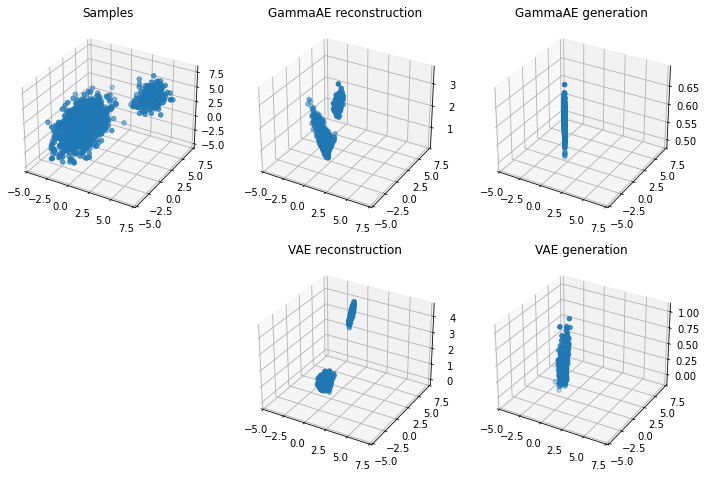

In [23]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2,3,1, projection='3d')
ax.scatter(t_sample.cpu().numpy()[:,0], 
           t_sample.cpu().numpy()[:,1], 
           t_sample.cpu().numpy()[:,2])
ax.set_xlim([-5, 7.5])
ax.set_ylim([-5, 7.5])


plt.title('Samples')
# plt.show()


# fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(2,3,2, projection='3d')
ax.scatter(gAE_reconstruction[:,0], 
           gAE_reconstruction[:,1], 
           gAE_reconstruction[:,2])
ax.set_xlim([-5, 7.5])
ax.set_ylim([-5, 7.5])
plt.title('GammaAE reconstruction')
# plt.show()


# fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(2,3,5, projection='3d')
ax.scatter(VAE_reconstruction[:,0], 
           VAE_reconstruction[:,1], 
           VAE_reconstruction[:,2])
ax.set_xlim([-5, 7.5])
ax.set_ylim([-5, 7.5])
plt.title('VAE reconstruction')
# plt.show()

# fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(2,3,3,projection='3d')
ax.scatter(gAE_sample[:,0], 
           gAE_sample[:,1], 
           gAE_sample[:,2])
ax.set_xlim([-5, 7.5])
ax.set_ylim([-5, 7.5])
plt.title('GammaAE generation')
# plt.show()


# fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(2,3,6, projection='3d')
ax.scatter(VAE_sample[:,0], 
           VAE_sample[:,1], 
           VAE_sample[:,2])
ax.set_xlim([-5, 7.5])
ax.set_ylim([-5, 7.5])
plt.title('VAE generation')
plt.show()